# Redes neuronales y máquinas de soporte vectorial

## Autor:   Ronie Martínez

#### Trabajo presentado como actividad propuesta para la asignatura "Aprendizaje Automático"

## Objetivo
Aplicar al conjunto de datos proporcionado los métodos o algoritmos de Redes Neuronales y Máquinas de Soporte Vectorial para predecir (regresión) el consumo (millas por galón) de unos vehículos.

## Información sobre los datos
El enlace: http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/ contiene los datos, la variable respuesta es “mpg”.

#### Pasos a seguir (orientativo)
- Análisis descriptivo de los datos
- Determinar el conjunto de modelización y el de validación
- Tratamiento de missing (si los hay)
- Tratamiento de variables categóricas
- Calcular las métricas de evaluación de ajuste adecuadas
- Comparar mediante las medidas que parezcan adecuadas la capacidad predictiva de ambos métodos
- Comentar los resultados obtenidos
- Otros comentarios que parezcan adecuados

## Inspección de los datos y pre-procesamiento

### Importamos las librerías necesarias

In [1]:
import numpy as np
import pandas as pd

# Visualización
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# SVM
from sklearn import svm, metrics
from sklearn.svm import SVR

# NN
#***Importante: tensorflow no viene instalado por defecto***
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

2.0.0-alpha0


### Cargamos el dataset
Contiene datos con características de varios automóviles dentro de un periodo de tiempo (1970 - 1982). Se incluyen atributos como: cilindros, desplazamiento, potencia, peso, aceleración, año del modelo, origen y millas por galón (columna target). 

No utilizamos la última columna denominada "car-name" debido a que por su naturaleza (string - único para cada instancia) no aporta nada para el modelado.

In [2]:
nombre_csv = 'auto-mpg.data.csv'
column_names = ['mpg', # contínua
                'cylinders', # discreta multivaluada
                'displacement', # contínua
                'horsepower', # contínua
                'weight', # contínua
                'acceleration', # contínua
                'model-year', # contínua
                'origin'] # contínua

# Creamos nuestro dataframe con la información proporcionada
raw_data = pd.read_csv(nombre_csv, names=column_names, na_values="?", 
                       comment='\t', sep=" ", skipinitialspace=True)

# Función display solo funciona en jupyter notebook!
print("Tamaño del dataset: ",raw_data.shape)
display(raw_data.head())

Tamaño del dataset:  (398, 8)


,mpg,cylinders,displacement,horsepower,weight,acceleration,model-year,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


### Tratamiento de missing y variables categóricas

In [3]:
# Duplicamos el dataset para no dañar el original
dataset = raw_data.copy()

# Limpiamos los datos
print(dataset.isna().sum()) # cantidad de datos no válidos

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model-year      0
origin          0
dtype: int64


Al tratarse solamente de 6 valores "missing", o desconocidos, en la columna "horsepower", podemos eliminarlos con la función _dropna()_

In [4]:
dataset = dataset.dropna() # dropeamos solamente 6 filas

La columna 'origin' se trata de una variable categórica:
- 1: USA
- 2: Europa
- 3: Japón

por lo que podemos dividirla en tres columnas independientes ("_one-hot encoding_").

In [5]:
origin = dataset.pop('origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
print("Tamaño del dataset: ",dataset.shape)
display(dataset.head())

Tamaño del dataset:  (392, 10)


,mpg,cylinders,displacement,horsepower,weight,acceleration,model-year,USA,Europe,Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,1.0,0.0,0.0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1.0,0.0,0.0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1.0,0.0,0.0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1.0,0.0,0.0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1.0,0.0,0.0


### Determinar el conjunto de modelización y el de validación

Para el proceso de "_hold-out_" se recomienda una relación de 80% - 20% entre el _training set_ y el _test set_. Adicionalmente es recomendable realizarlo de manera aleatoria debido a que se desconoce la naturaleza de la obtención de los datos.

In [6]:
# Split data
train_ds = dataset.sample(frac=0.8, random_state=0)
print("Training dataset shape: ",train_ds.shape)
test_ds = dataset.drop(train_ds.index)
print("Test dataset shape: ",test_ds.shape)

Training dataset shape:  (314, 10)
Test dataset shape:  (78, 10)


### Inspección de los datos

Como herramienta para visualización, podemos graficar la distribución conjunta y relación entre algunos atributos del _dataset_

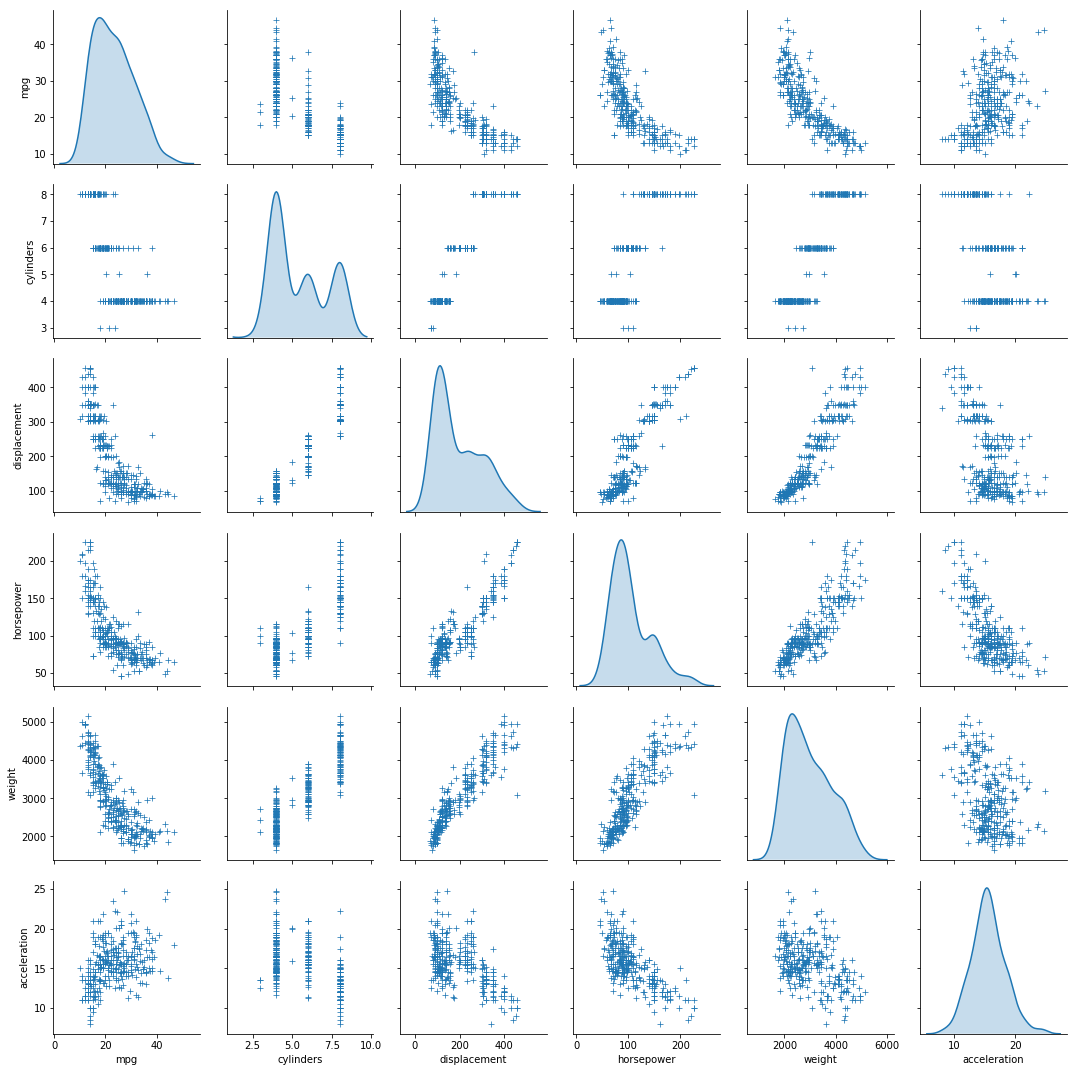

In [7]:
# Inspect the data
# https://seaborn.pydata.org/generated/seaborn.pairplot.html
import seaborn as sns
sns.pairplot(train_ds[['mpg', 
                'cylinders', 
                'displacement', 
                'horsepower', 
                'weight',
                'acceleration']], diag_kind='kde', markers="+", diag_kws=dict(shade=True))

Además, presentamos algunas estadísticas básicas del _dataset_ (_features_), por ejemplo: media, desviación estándar, entre otras.

In [8]:
train_stats = train_ds.describe()
train_stats.pop("mpg")
train_stats = train_stats.transpose()
display(train_stats)

,count,mean,std,min,25%,50%,75%,max
cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
model-year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


### Separamos la columna objetivo (_label_)
Separamos los valores de la columna 'mpg' que es el resultado en nuestro _dataset_

In [9]:
# Separación de la columna "resultado"
train_ls = train_ds.pop('mpg')
test_ls = test_ds.pop('mpg')

### Normalizamos los atributos (_features_)
La normalización de los datos es un paso muy importante previo al entrenamiento de nuestro modelo (tanto para SVM como para NN), ya que los atributos pueden tener rangos y valores muy variados y distintos.

In [10]:
# Creamos una función para realizar la normalización
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

train_ds_norm = norm(train_ds)
test_ds_norm = norm(test_ds)

## SVM (Support Vector Machine - Máquina de Vector de Soporte)

Para la evaluación se utilizan tres modelos diferentes de SVM:

- RBF - Radial Basis Function kernel
- Linear - lineal: es un algoritmo bastante rápido, generalmente se usa en problemas de clasificación multiclase (SVC) y en problemas con dataset extremadamente grande (miles de atributos).
- Polynomial - polinomial: debemos definir el grado del polinomio que queremos usar para la regresión

In [11]:
# Modelos
svr_rbf = SVR(kernel='rbf', C=10, gamma=0.1, epsilon=.1)
svr_lin = SVR(kernel='linear', C=10, gamma='auto')
svr_poly = SVR(kernel='poly', C=10, gamma='auto', degree=3, epsilon=.1, coef0=1)

# Train and predict
y_rbf = svr_rbf.fit(train_ds_norm, train_ls).predict(test_ds_norm)
y_lin = svr_lin.fit(train_ds_norm, train_ls).predict(test_ds_norm)
y_poly = svr_poly.fit(train_ds_norm, train_ls).predict(test_ds_norm)

Para las métricas de evaluación, vamos a utilizar:
- MSE - mean squared error
- MAE - mean absolute error

In [12]:
# Métricas de evaluación
print("(RBF)  mse: ", metrics.mean_squared_error(test_ls, y_rbf), 
      "- mae: ", metrics.mean_absolute_error(test_ls, y_rbf))
print("(Linear) mse: ", metrics.mean_squared_error(test_ls, y_lin), 
      "- mae: ", metrics.mean_absolute_error(test_ls, y_lin))
print("(Polynomial) mse: ", metrics.mean_squared_error(test_ls, y_poly), 
      "- mae: ", metrics.mean_absolute_error(test_ls, y_poly))

(RBF)  mse:  5.755111732831573 - mae:  1.7783071907413115
(Linear) mse:  12.180193915330065 - mae:  2.470827896317301
(Polynomial) mse:  5.461431762443463 - mae:  1.7239884225210766


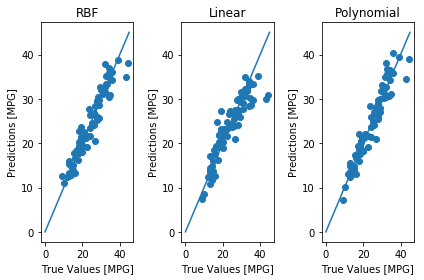

In [13]:
f, (ax0, ax1, ax2) = plt.subplots(1,3)
ax0.scatter(test_ls, y_rbf)
ax0.set_xlabel('True Values [MPG]')
ax0.set_ylabel('Predictions [MPG]')
ax0.set_title("RBF")
_ = ax0.plot([0, 45], [0, 45])

ax1.scatter(test_ls, y_lin)
ax1.set_xlabel('True Values [MPG]')
ax1.set_ylabel('Predictions [MPG]')
ax1.set_title("Linear")
_ = ax1.plot([0, 45], [0, 45])

ax2.scatter(test_ls, y_poly)
ax2.set_xlabel('True Values [MPG]')
ax2.set_ylabel('Predictions [MPG]')
ax2.set_title("Polynomial")
_ = ax2.plot([0, 45], [0, 45])

plt.tight_layout()
plt.show()

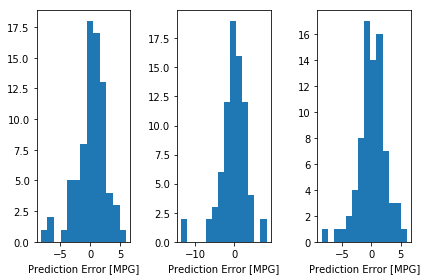

In [14]:
f, (ax0, ax1, ax2) = plt.subplots(1,3)
ax0.hist(y_rbf - test_ls, bins = 'fd')
ax0.set_xlabel('Prediction Error [MPG]')

ax1.hist(y_lin - test_ls, bins = 'fd')
ax1.set_xlabel('Prediction Error [MPG]')

ax2.hist(y_poly - test_ls, bins = 'fd')
ax2.set_xlabel('Prediction Error [MPG]')

plt.tight_layout()
plt.show()

## NN (Neural Network - Red Neuronal)

La librería de _scikit-learn_ contiene un método para redes neuronales (https://scikit-learn.org/stable/modules/neural_networks_supervised.html), sin embargo en la propia documentación se menciona que no está destinada para aplicaciones a gran escala. 

- from sklearn.neural_network import MLPRegressor

Adicionalmente, y como no se especifica qué método usar, se decidió por _tensorflow_ que es una librería ampliamente utilizada para el modelamiento de redes neuronales. Seguimos el notebook propuesto en la sección de ejemplos (https://www.tensorflow.org/tutorials/keras/basic_regression): 

### Creamos el modelo de la red neuronal

Definimos la topología de la red neuronal. Utilizamos un modelo secuencial con las siguietes características:
- capa de entrada: tamaño igual al número de atributos del _training dataset_
- capas ocultas: dos capas ocultas densamente conectadas (con 64 neuronas cada una)
- capa de salida: tamaño de uno, valor contínuo (problema de regresión)

In [15]:
# Modelo de la NN
model_nn = keras.Sequential([
    layers.Dense(64, activation=tf.nn.relu, input_shape=[len(train_ds.keys())]),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)])

optimizer = tf.keras.optimizers.RMSprop(0.001)

model_nn.compile(loss='mean_squared_error', 
                 optimizer=optimizer, 
                 metrics=['mean_absolute_error', 'mean_squared_error'])

model_nn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


### Entrenamiento del modelo

Entrenamos el modelo para 500 _epochs_ (máximo) y guardamos la precisión de entrenamiento y validación en el objeto "_history_"

In [16]:
# Función para mostrar el progreso del entrenamiento mediante 
# la impresión de un punto por cada epoch completada
# (**especialmente útil para modelos complejos y extensos**)
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

# El "patience parameter" es para revisar la mejora
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

# Entrenamiento
history = model_nn.fit(
  train_ds_norm, train_ls,
  epochs=500, validation_split = 0.2, verbose=0,
  callbacks=[early_stop, PrintDot()])


..............................................................

Imprimimos el objeto "_history_" para visualizar algunas métricas obtenidas

In [17]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
display(hist.head())
display(hist.tail())

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
0,562.801430,22.464619,562.801392,551.435757,22.174458,551.435791,0
1,510.996847,21.314701,510.996857,496.278144,20.913841,496.278137,1
2,458.885169,20.080292,458.885193,435.509783,19.452877,435.509796,2
3,399.988506,18.632492,399.988495,367.050157,17.694752,367.050171,3
4,335.500159,16.917356,335.500183,295.538321,15.688306,295.538330,4


,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
57,6.489985,1.862190,6.489985,9.432124,2.392969,9.432124,57
58,6.754607,1.821423,6.754607,9.160966,2.324851,9.160966,58
59,6.566574,1.849057,6.566574,8.973263,2.278783,8.973263,59
60,6.537585,1.850140,6.537584,9.102201,2.317390,9.102200,60
61,6.390612,1.811431,6.390612,9.829446,2.240606,9.829447,61


Impresión de las métricas en curvas comparativas (_training_ y _validation_) para revisar que no exista _overfiting_ o _underfiting_

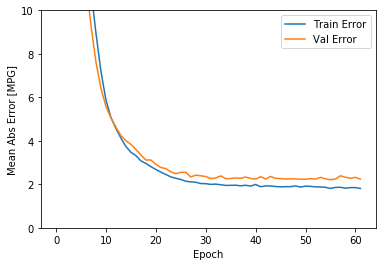

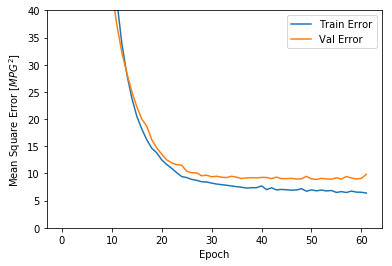

In [18]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,10])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,40])
  plt.legend()
  plt.show()

plot_history(history)

Las curvas se encuentran muy próximas y con valores bajos, por lo que se puede concluir que el modelo está funcionando correctamente.

Evaluamos el modelo en el _test set_

In [19]:
loss, mae, mse = model_nn.evaluate(test_ds_norm, test_ls, verbose=0)

print("Testing set Mean Squared Error: {:5.2f} MPG".format(mse))
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Squared Error:  7.30 MPG
Testing set Mean Abs Error:  2.17 MPG


Hacemos la predicción de 'mpg' para los datos del _testing set_

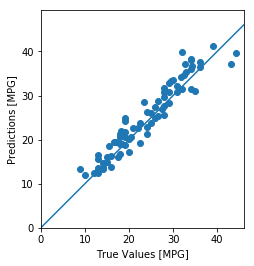

In [20]:
pred_ls = model_nn.predict(test_ds_norm).flatten()

plt.scatter(test_ls, pred_ls)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])

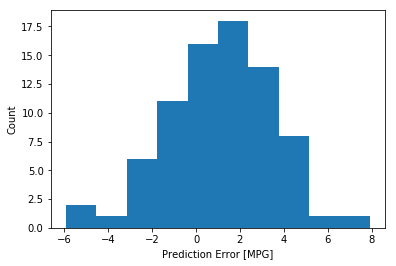

In [21]:
error = pred_ls - test_ls
plt.hist(error, bins = 'fd')#25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

## Comparación de los modelos
Ambos métodos explorados (SVM y NN) presentan un desempeño muy similar (excepto en el caso de SVM Linear).

Si los ordenamos en función de desempeño, de mejor a peor, tendríamos la siguiente lista:
- SVM Polynomial
- NN 64-64-1
- SVM RBF
- SVM Linear

Ahora, si bien el modelo de NN podría parecer mucho más complejo que cualquier otro modelo de SVM, la diferencia en cuanto a costo computacional y tiempo de respuesta (por lo menos para este ejercicio) no sería una complicación mayor a la hora de escoger el "mejor modelo".